In [ ]:
# !pip install tensorflow

In [ ]:
from google.colab import drive
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Resizing
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load pickled dataset
with open("/content/drive/My Drive/Graduation Project/Graduation Project 2/df_all_balanced_package.pkl", "rb") as f:
    df_all = pickle.load(f)

X_train_cnn = df_all["X_train_cnn"]
X_train_conn = df_all["X_train_conn"]
y_train = df_all["y_train"]
X_val_cnn = df_all["X_val_cnn"]
X_val_conn = df_all["X_val_conn"]
y_val = df_all["y_val"]
X_test_cnn = df_all["X_test_cnn"]
X_test_conn = df_all["X_test_conn"]
y_test = df_all["y_test"]

In [ ]:
def print_stats(y, name):
    n_single = np.sum(np.sum(y, axis=1) == 1)
    n_multi = np.sum(np.sum(y, axis=1) > 1)
    print(f"=== {name} Set ===")
    print(f"Single-label: {n_single} ({n_single/len(y)*100:.1f}%)")
    print(f"Multi-label: {n_multi} ({n_multi/len(y)*100:.1f}%)")

print_stats(y_train, "Train")
print_stats(y_test, "Test")
print_stats(y_val, "Validation")

=== Train Set ===
Single-label: 26496 (56.0%)
Multi-label: 20819 (44.0%)
=== Test Set ===
Single-label: 4843 (81.9%)
Multi-label: 1071 (18.1%)
=== Validation Set ===
Single-label: 4844 (81.9%)
Multi-label: 1072 (18.1%)


In [ ]:
cnn_input_shape = (256, 256, 3)
conn_input_shape = (3,)
num_classes = 13  # Updated to 13 after removing Hernia

In [ ]:
cnn_input = Input(shape=cnn_input_shape, name='cnn_input')

# MobileNetV2 architecture
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=cnn_input)
base_output = base_model.output

x = GlobalAveragePooling2D()(base_output)
x = Dropout(0.3)(x)

# Connected input
conn_input = Input(shape=conn_input_shape, name='conn_input')
y = Dense(64, activation='relu')(conn_input)
y = Dropout(0.3)(y)

# Combine
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(num_classes, activation='sigmoid')(z)

# Model
model = Model(inputs=[cnn_input, conn_input], outputs=output)

<ipython-input-8-b73bdb30b9fa>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=cnn_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[
        Accuracy(name='accuracy'),
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,345,165 (8.95 MB)

 Trainable params: 2,311,053 (8.82 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1, mode='min'),
    ModelCheckpoint("/content/drive/My Drive/Graduation Project/Graduation Project 2/Models/SavedModels2/Best_MobileNetV2.keras",
                    monitor='val_auc', save_best_only=True, mode='max', verbose=1)
]

In [ ]:
# Train the model
history = model.fit(
    [X_train_cnn, X_train_conn],
    y_train,
    validation_data=([X_val_cnn, X_val_conn], y_val),
    epochs=40,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.6727 - loss: 0.3991
Epoch 1: val_auc improved from -inf to 0.79894, saving model to /content/drive/My Drive/Graduation Project/Graduation Project 2/Models/SavedModels2/Best_MobileNetV2.keras
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 2299s 2s/step - auc: 0.6727 - loss: 0.3991 - val_auc: 0.7989 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 2/40
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.8513 - loss: 0.2839
Epoch 2: val_auc improved from 0.79894 to 0.84449, saving model to /content/drive/My Drive/Graduation Project/Graduation Project 2/Models/SavedModels2/Best_MobileNetV2.keras
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 2249s 2s/step - auc: 0.8513 - loss: 0.2839 - val_auc: 0.8445 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 3/40
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.8969 - loss: 0.2428
Epoch 3: val_auc improved from 0.84449 to 0.89365, saving model to /content/drive/My Drive/Graduation Project/Graduation Project 2/

In [ ]:
# Save the model
model.save("/content/drive/My Drive/Graduation Project/Graduation Project 2/Models/SavedModels2/MobileNetV2.h5")
model.save("/content/drive/My Drive/Graduation Project/Graduation Project 2/Models/SavedModels2/MobileNetV2.keras")

In [ ]:
# Evaluate the model on test data
y_pred = model.predict([X_test_cnn, X_test_conn])
y_pred_bin = (y_pred > 0.5).astype(int)

# Print evaluation metrics
print("AUC:", roc_auc_score(y_test, y_pred, average='macro'))
print("Precision:", precision_score(y_test, y_pred_bin, average='macro'))
print("Recall:", recall_score(y_test, y_pred_bin, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_bin, average='macro'))

185/185 ━━━━━━━━━━━━━━━━━━━━ 52s 278ms/step
AUC: 0.9658071751838674
Precision: 0.7530434067376011
Recall: 0.7316941717273558
F1 Score: 0.7402374387573769


In [ ]:
# Classification report
class_names = [
    "Cardiomegaly", "Emphysema", "Effusion", "Infiltration",
    "Mass", "Nodule", "Atelectasis", "Pneumothorax", "Pleural_Thickening",
    "Pneumonia", "Fibrosis", "Edema", "Consolidation"
]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_bin, target_names=class_names))


Classification Report:

                    precision    recall  f1-score   support

      Cardiomegaly       0.93      0.90      0.91       732
         Emphysema       0.91      0.93      0.92       718
          Effusion       0.63      0.47      0.54       366
      Infiltration       0.45      0.52      0.48       381
              Mass       0.67      0.65      0.66       561
            Nodule       0.57      0.66      0.61       639
       Atelectasis       0.41      0.35      0.38       255
      Pneumothorax       0.71      0.65      0.68       541
Pleural_Thickening       0.86      0.85      0.85       652
         Pneumonia       0.96      0.95      0.95       796
          Fibrosis       0.92      0.95      0.94       715
             Edema       0.92      0.94      0.93       715
     Consolidation       0.84      0.71      0.77       615

         micro avg       0.80      0.78      0.79      7686
         macro avg       0.75      0.73      0.74      7686
      weighte

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Tune Thresholds per Class

In [ ]:
val_preds = model.predict([X_val_cnn, X_val_conn])

185/185 ━━━━━━━━━━━━━━━━━━━━ 31s 168ms/step


In [ ]:
np.where(np.sum(y_train, axis=1) > 5)[0]

array([26515, 26544, 26563, 26583, 26656, 26694, 27019, 27094, 27117,
       27136, 27178, 27259, 27285, 27330, 27403, 27489, 27517, 27577,
       27643, 27764, 27797, 27916, 27926, 28059, 28062, 28071, 28082,
       28104, 28280, 28332, 28356, 28358, 28375, 28520, 28565, 28806,
       28917, 29100, 29103, 29317, 29364, 29451, 29724, 29753, 29803,
       29988, 30030, 30161, 30189, 30258, 30368, 30400, 30477, 30520,
       30591, 30657, 30726, 30792, 30930, 30980, 30983, 31144, 31381,
       31424, 31437, 31745, 31798, 31807, 31888, 31949, 31988, 32001,
       32040, 32109, 32134, 32198, 32282, 32347, 32569, 32577, 32585,
       32601, 32795, 32830, 32872, 33170, 33173, 33254, 33289, 33408,
       33553, 33614, 33621, 33679, 33785, 33904, 33923, 33928, 34088,
       34119, 34127, 34144, 34173, 34200, 34229, 34241, 34308, 34345,
       34360, 34486, 34588, 34601, 34739, 34757, 34823, 34836, 34864,
       34915, 34926, 35115, 35308, 35484, 35693, 35781, 35800, 35987,
       35994, 36110,

In [ ]:
index_to_test = 26515

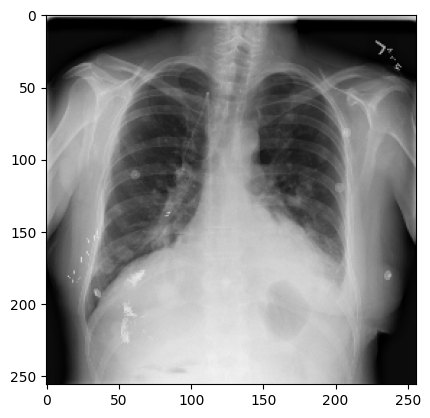

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train_cnn[index_to_test].astype("float32") , cmap='gray')
plt.show()

In [ ]:
y_train[index_to_test]

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
import numpy as np

cnn_input = np.expand_dims(X_train_cnn[index_to_test], axis=0)

conn_input = np.expand_dims(X_train_conn[index_to_test], axis=0)

print(cnn_input.shape)
print(conn_input.shape)

(1, 256, 256, 3)
(1, 3)


In [ ]:
model.predict([cnn_input ,conn_input])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


array([[0.00444762, 0.0455217 , 0.70111763, 0.8010663 , 0.8856421 ,
        0.6005825 , 0.54174197, 0.31907395, 0.7165319 , 0.00781961,
        0.08429855, 0.0116186 , 0.646518  ]], dtype=float32)

In [ ]:
# Get prediction
predictions = model.predict([cnn_input, conn_input])[0]  # shape: (13,)
percentages = predictions * 100
sorted_indices = np.argsort(predictions)[::-1]

# Class names (13 total)
class_names = [
    "Cardiomegaly", "Emphysema", "Effusion", "Infiltration",
    "Mass", "Nodule", "Atelectasis", "Pneumothorax", "Pleural_Thickening",
    "Pneumonia", "Fibrosis", "Edema", "Consolidation"
]

# Display predictions
print("🔍 Model Predictions (Sorted):\n")
for idx, i in enumerate(sorted_indices, 1):
    print(f"{class_names[i]:<25}[{i}] : {percentages[i]:.2f}%" ," || ")

print("disease index : " ,np.where(y_train[index_to_test] == 1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
🔍 Model Predictions (Sorted):

Mass                     [4] : 88.56%  || 
Infiltration             [3] : 80.11%  || 
Pleural_Thickening       [8] : 71.65%  || 
Effusion                 [2] : 70.11%  || 
Consolidation            [12] : 64.65%  || 
Nodule                   [5] : 60.06%  || 
Atelectasis              [6] : 54.17%  || 
Pneumothorax             [7] : 31.91%  || 
Fibrosis                 [10] : 8.43%  || 
Emphysema                [1] : 4.55%  || 
Edema                    [11] : 1.16%  || 
Pneumonia                [9] : 0.78%  || 
Cardiomegaly             [0] : 0.44%  || 
disease index :  [ 2  3  4  5  7  8 12]


In [ ]:
def find_best_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        best_thresh = 0.5
        best_f1 = 0
        for thresh in np.arange(0.1, 0.9, 0.01):
            preds = (y_probs[:, i] > thresh).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        thresholds.append(best_thresh)
    return np.array(thresholds)

# Compute best thresholds
best_thresholds = find_best_thresholds(y_val, val_preds)
print("Best thresholds per class:\n", best_thresholds)

Best thresholds per class:
 [0.19 0.38 0.53 0.37 0.5  0.38 0.44 0.5  0.38 0.78 0.17 0.71 0.67]


In [ ]:
# Make predictions using best thresholds
test_probs = model.predict([X_test_cnn, X_test_conn])
test_preds = np.zeros_like(test_probs)

for i in range(test_probs.shape[1]):
    test_preds[:, i] = (test_probs[:, i] > best_thresholds[i]).astype(int)

185/185 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step


In [ ]:
# Final evaluation
print("AUC:", roc_auc_score(y_test, test_probs, average='macro'))
print("Precision:", precision_score(y_test, test_preds, average='macro'))
print("Recall:", recall_score(y_test, test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, test_preds, average='macro'))

AUC: 0.9466037253551733
Precision: 0.748946580864032
Recall: 0.7474367775566748
F1 Score: 0.7461540974453637


In [ ]:
print("\nPer-Class Classification Report:\n")
print(classification_report(y_test, test_preds, target_names=class_names))


Per-Class Classification Report:

                    precision    recall  f1-score   support

      Cardiomegaly       0.85      0.84      0.85       712
         Emphysema       0.88      0.88      0.88       719
          Effusion       0.62      0.66      0.64       825
      Infiltration       0.50      0.63      0.55       859
              Mass       0.66      0.75      0.70       852
            Nodule       0.63      0.71      0.67       925
       Atelectasis       0.46      0.51      0.48       527
      Pneumothorax       0.74      0.75      0.75       757
Pleural_Thickening       0.82      0.77      0.79       746
         Pneumonia       0.99      0.81      0.89       692
          Fibrosis       0.94      0.88      0.91       684
             Edema       0.90      0.82      0.86       669
     Consolidation       0.75      0.71      0.73       802

         micro avg       0.73      0.75      0.74      9769
         macro avg       0.75      0.75      0.75      9769
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
